In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction
directory = 'lorenz/'


# dyn_lorenz = {"sigma":16.0, "R":45.92, "b": 4.0}
dyn_lorenz = {"sigma":10.0, "R":28.0, "b": 8/3}
x0 = np.array([10.0, 1.0, 0.0])
v1 = np.array([1.0, 0.0, 0.0])
v2 = np.array([0.0, 1.0, 0.0])
v3 = np.array([0.0, 0.0, 1.0])
x_dot = []
x_norm = []
# cum = np.array([0,0,0])

def lorenz (x0, dyn):
    sigma = dyn['sigma']
    R = dyn['R']
    b = dyn['b']
    x = x0[0]
    y = x0[1]
    z = x0[2]
    return np.array([sigma * (y - x), 
                     x * (R - z) - y, 
                     x * y - b * z])

def linearized_lorenz (x0, dyn, y_lorenz):
    sigma = dyn['sigma']
    R = dyn['R']
    b = dyn['b']
    x = x0[0]
    y = x0[1]
    z = x0[2]
    return np.array([sigma * (y - x), 
                     (R - y_lorenz[2])*x - y - y_lorenz[0]*z,
                      y_lorenz[1]*x + y_lorenz[0]*y - b*z])


def RungeKutta_for_collect_trajectory (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    x_norm.append(x0)
    x_dot.append(k4)
    return x

def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    return x

def RungeKutta_linearized (dyn, f, dt, x0, y):
    k1 = f(x0, dyn, y) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn, y)
    k3 = f(x0 + 0.5*k2*dt, dyn, y)
    k4 = f(x0 + k3*dt, dyn, y)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) * dt

    return x

def f_t_collect_trajectory  (dyn, f, linearized_f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    v1_prime = np.empty(shape=(len(x0),T))
    v2_prime = np.empty(shape=(len(x0),T))
    v3_prime = np.empty(shape=(len(x0),T))
    x[:, 0] = x0
    v1_prime[:, 0] = v1
    v2_prime[:, 0] = v2
    v3_prime[:, 0] = v3
    cum = np.array([0,0,0])
    for i in range(1,T):
        x[:, i] = RungeKutta_for_collect_trajectory(dyn, f, dt, x[:, i-1])
        
        v1_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v1_prime[:, i-1], x[:, i-1])
        v2_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v2_prime[:, i-1], x[:, i-1])
        v3_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v3_prime[:, i-1], x[:, i-1])
        
        
        norm1 = np.linalg.norm(v1_prime[:, i])
        v1_prime[:, i] = v1_prime[:, i]/norm1
        
        GSC1 = np.dot(v1_prime[:, i], v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i] - GSC1*v1_prime[:, i]
        
        norm2 = np.linalg.norm(v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i]/norm2
        
        GSC2 = np.dot(v3_prime[:, i], v1_prime[:, i])
        GSC3 = np.dot(v3_prime[:, i], v2_prime[:, i])
        
        v3_prime[:, i] = v3_prime[:, i] - GSC2*v1_prime[:, i] - GSC3*v2_prime[:, i]
        norm3 = np.linalg.norm(v3_prime[:, i])
        v3_prime[:, i] = v3_prime[:, i]/norm3
        cum = cum + np.log2(np.array([norm1,norm2,norm3]))
#         if ( i % 100 == 0 ):
#             print ('log2:', np.log2(np.array([norm1,norm2,norm3]))/(i*dt))
#             print ('cum:', cum/(i*dt))
        
        
    return x, cum/(i*dt)

def f_t (dyn, f, linearized_f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    v1_prime = np.empty(shape=(len(x0),T))
    v2_prime = np.empty(shape=(len(x0),T))
    v3_prime = np.empty(shape=(len(x0),T))
    x[:, 0] = x0
    v1_prime[:, 0] = v1
    v2_prime[:, 0] = v2
    v3_prime[:, 0] = v3
    cum = np.array([0,0,0])
    for i in range(1,T):
        x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1])
        
        v1_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v1_prime[:, i-1], x[:, i-1])
        v2_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v2_prime[:, i-1], x[:, i-1])
        v3_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v3_prime[:, i-1], x[:, i-1])
        
        
        norm1 = np.linalg.norm(v1_prime[:, i])
        v1_prime[:, i] = v1_prime[:, i]/norm1
        
        GSC1 = np.dot(v1_prime[:, i], v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i] - GSC1*v1_prime[:, i]
        
        norm2 = np.linalg.norm(v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i]/norm2
        
        GSC2 = np.dot(v3_prime[:, i], v1_prime[:, i])
        GSC3 = np.dot(v3_prime[:, i], v2_prime[:, i])
        
        v3_prime[:, i] = v3_prime[:, i] - GSC2*v1_prime[:, i] - GSC3*v2_prime[:, i]
        norm3 = np.linalg.norm(v3_prime[:, i])
        v3_prime[:, i] = v3_prime[:, i]/norm3
        cum = cum + np.log2(np.array([norm1,norm2,norm3]))
#         if ( i % 100 == 0 ):
#             print ('log2:', np.log2(np.array([norm1,norm2,norm3]))/(i*dt))
#             print ('cum:', cum/(i*dt))
        
        
    return x, cum/(T*dt)



In [745]:
x, _ = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, x0, 10000)
x_dot_np = np.array(x_dot)
x_norm_np =np.array(x_norm)
lorenz_cum = []

for i in range(len(x[0])):
#     print (x[:,i])
    _, cum_temp = f_t_collect_trajectory(dyn_lorenz, lorenz, linearized_lorenz, 0.1, x[:,i], 2500)
    lorenz_cum.append(cum_temp)
    
zs = np.array([i[0] for i in lorenz_cum])

KeyboardInterrupt: 

In [ ]:
zs = zs[0:9999]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
ax.set_title('x vs. x dot')
ax.set_xlabel('x')
ax.set_ylabel('x_dot')
plot = ax.scatter(x_norm_np.T[0], x_dot_np.T[0], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar = fig.colorbar(plot, shrink=0.6, aspect=5)

ax1 = fig.add_subplot(222)
ax1.set_title('y vs. y dot')
ax1.set_xlabel('y')
ax1.set_ylabel('y_dot')
plot1 = ax1.scatter(x_norm_np.T[1], x_dot_np.T[1], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)

ax2 = fig.add_subplot(223)
ax2.set_title('z vs. z dot')
ax2.set_xlabel('z')
ax2.set_ylabel('z_dot')
plot2 = ax2.scatter(x_norm_np.T[2], x_dot_np.T[2], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar2 = fig.colorbar(plot2, shrink=0.6, aspect=5)

fig.suptitle('axis vs. dot axis', fontsize=18)
fig.tight_layout()
plt.savefig('axis_dot.png')

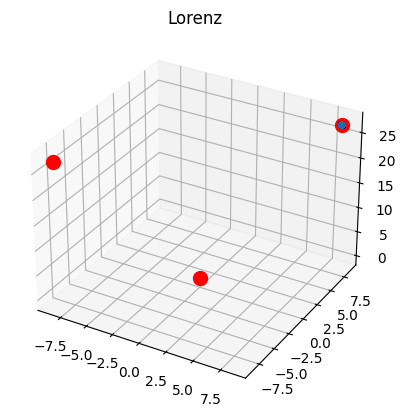

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(8.485, 8.485, 27, s=100, c='red', marker='o')
ax.scatter(-8.485, -8.485, 27, s=100, c='red', marker='o')
ax.scatter(0,0,0 , s=100, c='red', marker='o')

x, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.1, np.array([8.485,8.485,27]), 00)
plt.title('Lorenz')
cube = ax.scatter(x[0], x[1], x[2], alpha=0.1)

plt.show()

In [128]:
cum

array([  0.61379074,   0.19921285, -16.58619936])

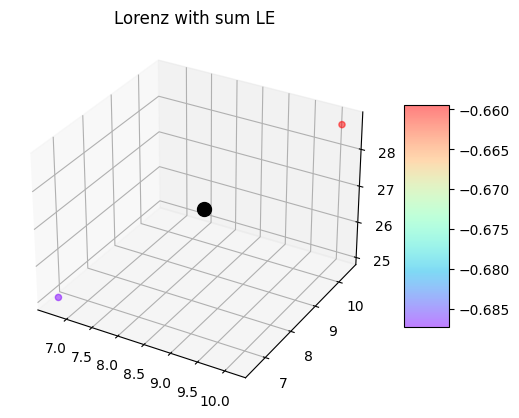

In [384]:
x, _ = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, x0, 100000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(8.485, 8.485, 27, s=100, c='black', marker='o')
# ax.scatter(8.485, 8.485, 27, s=100, c='black', marker='o')
# ax.scatter(0, 0, 0, s=100, c='black', marker='o')

test = []
for i in x.T:
    if  8.485 - 2 <= i[0] <= 8.485 + 2:
        if  8.485 - 2 <= i[1] <= 8.485 + 2:
            if  27 - 2 <= i[2] <= 27 + 2:
                test.append(i)
x = np.array(test).T

lorenz_cum = []
for i in range(len(x[0])):
#     print (x[:,i])
    _, cum_temp = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, x[:,i], 100)
    lorenz_cum.append(cum_temp)
    
# zs = np.array([np.sum(i) for i in lorenz_cum])
zs = np.array([i[0] for i in lorenz_cum])

# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
plt.title('Lorenz with sum LE')
cube = ax.scatter(x[0], x[1], x[2], zdir='z', c=zs, cmap=plt.cm.rainbow, alpha=0.5)
cbar = fig.colorbar(cube, shrink=0.6, aspect=5)

plt.savefig('Lorenz_attractor_sumLE.png')
plt.show()


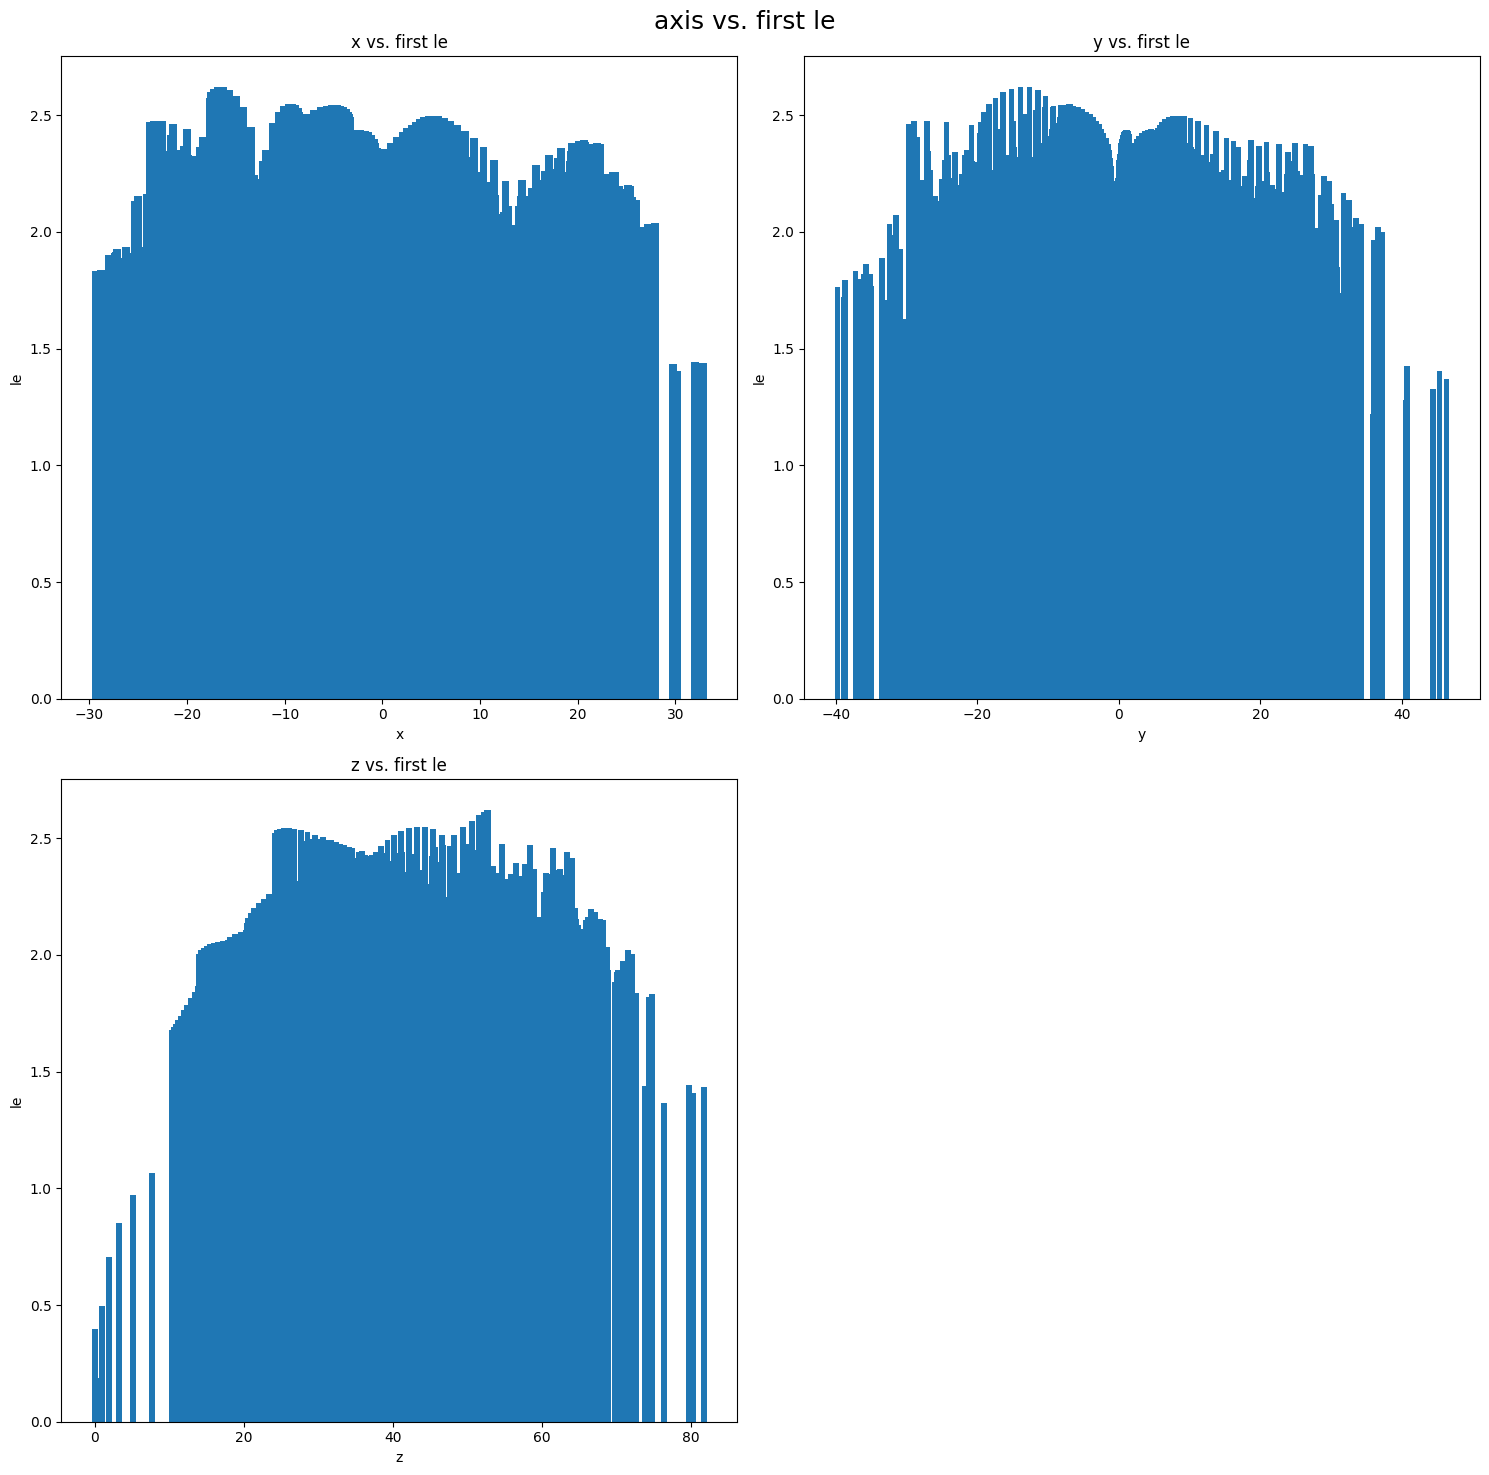

In [138]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
ax.set_title('x vs. first le')
ax.set_xlabel('x')
ax.set_ylabel('le')
ax.bar(x[0], zs)

ax1 = fig.add_subplot(222)
ax1.set_title('y vs. first le')
ax1.set_xlabel('y')
ax1.set_ylabel('le')
ax1.bar(x[1], zs)

ax2 = fig.add_subplot(223)
ax2.set_title('z vs. first le')
ax2.set_xlabel('z')
ax2.set_ylabel('le')
ax2.bar(x[2], zs)

fig.suptitle('axis vs. first le', fontsize=18)
fig.tight_layout()
plt.savefig('axis_firstle.png')

In [607]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

_, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  10, 1, 0]), 550000)

In [153]:
_, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  10, 1, 0]), 550000)

In [551]:
cum

array([ 1.29270955e+00, -3.07880697e-03, -2.10063125e+01])

In [626]:
np.sqrt(8/3*(28-1))

8.48528137423857

In [701]:
_, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  np.sqrt(8/3*(28-1)), np.sqrt(8/3*(28-1)), 28-1]), 900)

In [702]:
cum

array([  0.0376669 ,   0.0872025 , -19.84163619])

In [673]:
_, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.001, np.array([  -np.sqrt(8/3*(28-1)), -np.sqrt(8/3*(28-1)), 28-1]), 1000)

In [674]:
cum

array([ -0.7578784 ,  -0.28690809, -18.67204573])

In [102]:
cum_, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  -np.sqrt(8/3*(28-1))+0.1, -np.sqrt(8/3*(28-1)), 28-1]), 1000)

In [103]:
cum

array([  0.03445901,   0.10537966, -19.83688868])

In [4]:
_, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  7.777, 7.57, 29]), 100)

In [5]:
cum

array([ -0.82923781,  -0.17864579, -18.70887928])

In [88]:
x, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  21.87742005,  1.03011196, 37.08110233]), 100)

In [116]:
x, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, np.array([  
    0,  
    0, 
    0]), 1000)

In [117]:
cum

array([ 17.02968699, -32.88258702,  -3.84333957])

In [42]:
test = np.array([  np.full(500,fill_value=8.485),np.random.uniform(8.485-10, 8.485+10, size=(500)), np.full(500,27)])

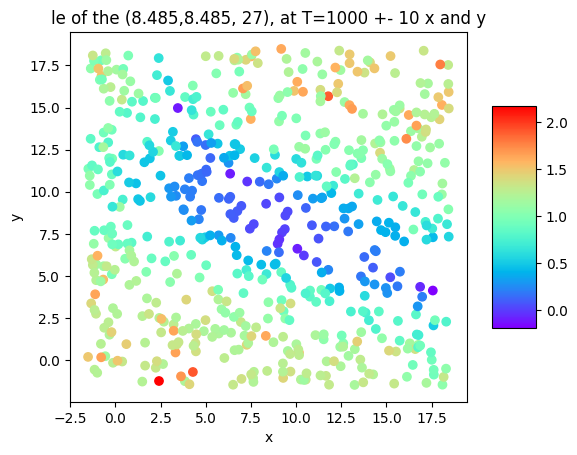

In [152]:
# x, y for (8.485,8.485, 27)

r = 10
T = 1000

test = np.array([  np.random.uniform(8.485-r, 8.485+r, size=(600)), 
                 np.random.uniform(8.485-r, 8.485+r, size=(600)), 
                 np.full(600,fill_value=27)])
# new_test = np.append(test.T,np.array([[8.485,8.485,27]]),axis=0)
# test = new_test.T
cum_list = []
for i in test.T:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, T)
    cum_list.append(cum)
fig = plt.figure()
ax = fig.add_subplot(111)
zs = np.array([i[0] for i in cum_list])
plot1 = ax.scatter(test[0], test[1], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title ('le of the (8.485,8.485, 27), at T={} +- {} x and y'.format(T,r))
plt.show()

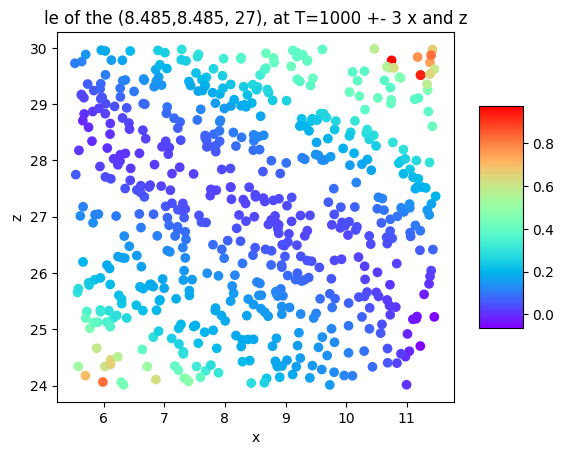

In [150]:
# x, z for (8.485,8.485, 27)

r = 3
T = 1000

test = np.array([  np.random.uniform(8.485-r, 8.485+r, size=(600)),
                 np.full(600,fill_value=8.485), 
                 np.random.uniform(27-r, 27+r, size=(600))])
new_test = np.append(test.T,np.array([[8.485,8.485,27]]),axis=0)
test = new_test.T
cum_list = []
for i in test.T:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, T)
    cum_list.append(cum)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(0, 0, 0, s=200, c='black', marker='o')
# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
# ax.scatter(8.485, 27, c='black', marker='o')
zs = np.array([i[0] for i in cum_list])
plot1 = ax.scatter(test[0], test[2], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.title ('le of the (8.485,8.485, 27), at T={} +- {} x and z'.format(T,r))
plt.show()

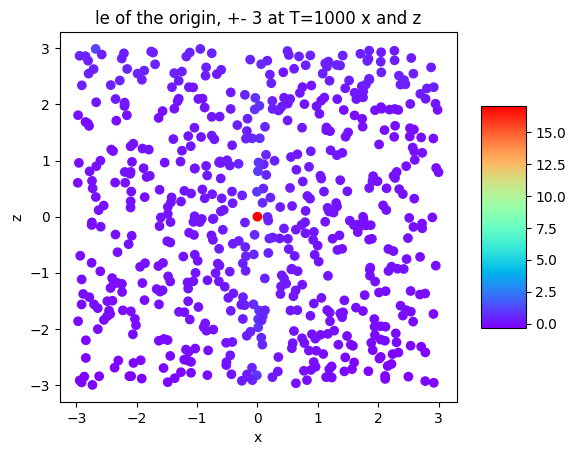

In [151]:
# x, z for (0,0,0)


r = 3
T = 1000

test = np.array([  np.random.uniform(0-r, 0+r, size=(600)), 
                 np.full(600,fill_value=0), 
                 np.random.uniform(0-r, 0+r, size=(600))])
new_test = np.append(test.T,np.array([[0,0,0]]),axis=0)
test = new_test.T
cum_list = []
for i in test.T:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, T)
    cum_list.append(cum)
fig = plt.figure()
ax = fig.add_subplot(111)
zs = np.array([i[0] for i in cum_list])
plot1 = ax.scatter(test[0], test[2], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.title ('le of the origin, +- {} at T={} x and z'.format(r,T))
plt.show()

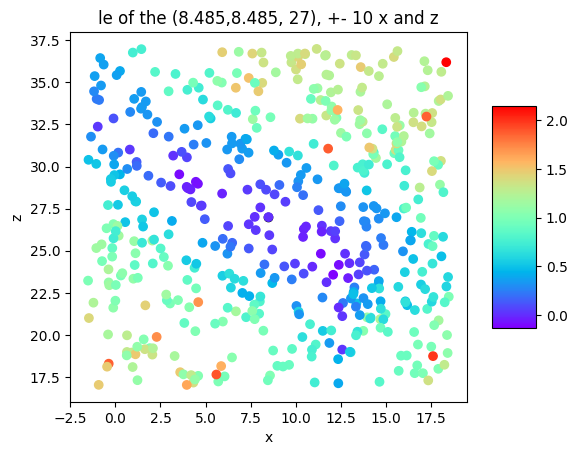

In [125]:
test = np.array([  np.random.uniform(8.485-10, 8.485+10, size=(500)),
                 np.full(500,fill_value=8.485), 
                 np.random.uniform(27-10, 27+10, size=(500))])
new_test = np.append(test.T,np.array([[8.485,8.485,27]]),axis=0)
test = new_test.T
cum_list = []
for i in test.T:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, 801)
    cum_list.append(cum)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(0, 0, 0, s=200, c='black', marker='o')
# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
ax.scatter(8.485, 27, c='black', marker='o')
zs = np.array([i[0] for i in cum_list])
plot1 = ax.scatter(test[0], test[2], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.title ('le of the (8.485,8.485, 27), +- 10 x and z')
plt.show()

In [42]:
# at around 0.01 +- 0.005, x,z seems to change at the same rate
# at around 0.001 +- 0.005, z seems to change faster than x
# above 0.09, x seems to change faster than z

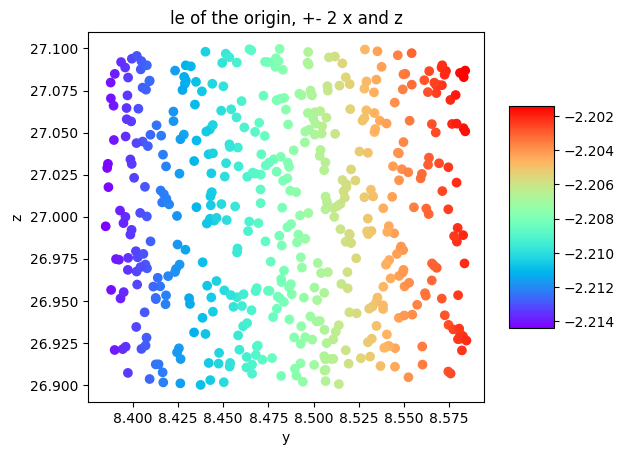

In [57]:
test = np.array([  np.full(500,fill_value=8.485), np.random.uniform(8.485-0.1, 8.485+0.1, size=(500)), np.random.uniform(27-0.1, 27+0.1, size=(500))])
cum_list = []
for i in test.T:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, 50)
    cum_list.append(cum)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(0, 0, 0, s=200, c='black', marker='o')
# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
zs = np.array([i[0] for i in cum_list])
plot1 = ax.scatter(test[1], test[2], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.title ('le of the origin, +- 2 x and z')
plt.show()

In [104]:
np.append(test.T,np.array([[0,0,0]]),axis=0)

array([[ 0.16762706,  0.        ,  5.53333495],
       [-9.12085311,  0.        ,  9.30417183],
       [-4.54086273,  0.        , -3.86717189],
       ...,
       [ 9.00084172,  0.        ,  7.3097349 ],
       [ 4.81760654,  0.        , -9.07608334],
       [ 0.        ,  0.        ,  0.        ]])

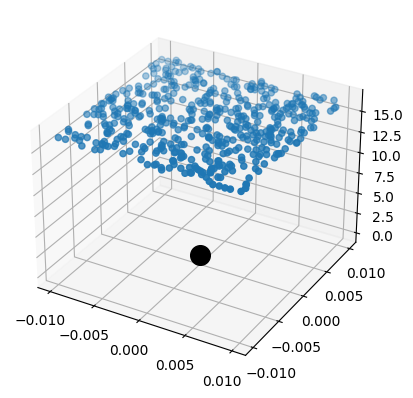

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, s=200, c='black', marker='o')
# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
cube = ax.scatter(test[0], test[2], zs)


plt.show()

In [ ]:
2d z and x lyapunov exponents
ground trajectory at 0 (bound at 0)
penalize at origin or equiribribum
quadratic penalty (neg what reward we have before)
double pendulum vs pendulum
visualization

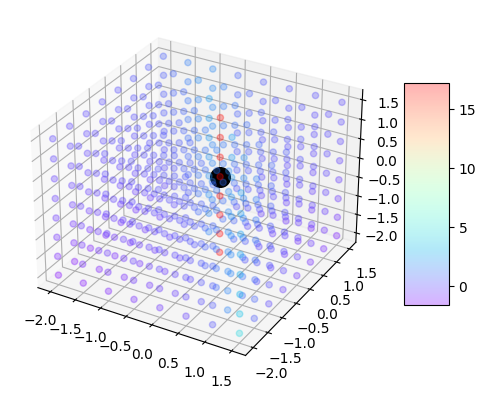

In [769]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Make the 3D grid
X, Y, Z = np.meshgrid(np.arange(0 - 2 , 0 + 2, 0.5),
                      np.arange(0 - 2 , 0 + 2, 0.5),
                      np.arange(0 - 2 , 0 + 2, 0.5))

l = []
for i in range(len(X)):
    for j in range(len(Y)):
        for k in range(len(Z)):
            l.append(np.array([X[i][j][k],Y[i][j][k],Z[i][j][k]]))

cum_list = []
for i in l:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, 200)
    cum_list.append(cum)

#first components
zs = np.array([i[0] for i in cum_list])
#sum of all components
# zs = np.array([np.sum(i) for i in cum_list])
# ax.scatter(-8.485, -8.485, 27, s=200, c='black', marker='o')
# ax.scatter(8.485, 8.485, 27, s=200, c='black', marker='o')
ax.scatter(0, 0, 0, s=200, c='black', marker='o')
# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
cube = ax.scatter(X, Y, Z, zdir='z', c=zs, cmap=plt.cm.rainbow, alpha=0.3)
cbar = fig.colorbar(cube, shrink=0.6, aspect=5)


plt.show()

In [750]:
# Make the 3D grid
X, Y = np.meshgrid(np.arange(0 - 8,0 + 8, 1),
                      np.arange(0 - 8, 0 + 8, 1))

l = []
for i in range(len(X)):
    for j in range(len(Y)):
            l.append(np.array([X[i][j],Y[i][j],0]))

cum_list = []
for i in l:
    _, cum = f_t(dyn_lorenz, lorenz, linearized_lorenz, 0.01, i, 500)
    cum_list.append(cum)

#first components
zs = np.array([i[0] for i in cum_list])
#sum of all components
# zs = np.array([np.sum(i) for i in cum_list])
# ax.scatter(-8.485, -8.485, 27, s=200, c='black', marker='o')
# ax.scatter(8.485, 8.485, 27, s=200, c='black', marker='o')


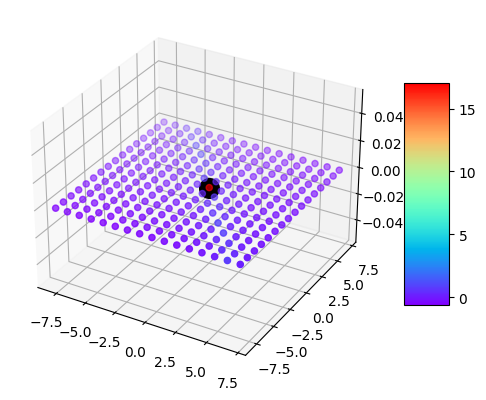

In [751]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, s=200, c='black', marker='o')
# zs = (zs-np.min(zs))/(np.max(zs)-np.min(zs))
larray = np.array(l)
cube = ax.scatter(larray.T[0], larray.T[1], larray.T[2], c=zs, cmap=plt.cm.rainbow)
cbar = fig.colorbar(cube, shrink=0.6, aspect=5)


plt.show()

In [440]:
zs = np.array([np.sum(i) for i in cum_list])

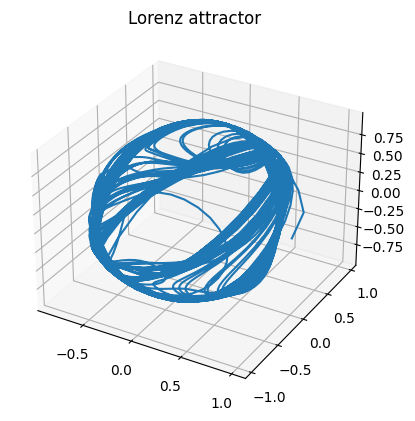

In [97]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(v1_prime[0], v1_prime[1], v1_prime[2])
# ax.scatter3D(-8.485, -8.485, 27, s=100, color="red")
plt.title('Lorenz attractor')
plt.draw()